In [1]:
import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from textblob import TextBlob    # import textblob packages, nlp
from textblob.sentiments import NaiveBayesAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import natural language toolkit
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sairamyerramshetty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [121]:
df = pd.read_csv("Reviews.csv", dtype={'Text': str},nrows = 10000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


In [ ]:
df.head()

In [3]:
column = "Text"

In [4]:
print("Summary statistics of numerical data")
print(df.describe())

print("\nTotal number of reviews", df.shape[0])

def rating_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"
df["rating_sentiment"] = df["Score"].apply(rating_sentiment)
print("\nRatio of Positive vs. Neutral vs. Negative Review Sentiment : (all in percentage)")
print(df["rating_sentiment"].value_counts()/df.shape[0] * 100)

Summary statistics of numerical data
                Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  10000.00000          10000.000000            10000.000000   
mean    5000.50000              1.573500                2.014900   
std     2886.89568              5.230634                5.807551   
min        1.00000              0.000000                0.000000   
25%     2500.75000              0.000000                0.000000   
50%     5000.50000              0.000000                1.000000   
75%     7500.25000              2.000000                2.000000   
max    10000.00000            187.000000              216.000000   

              Score          Time  
count  10000.000000  1.000000e+04  
mean       4.134500  1.294359e+09  
std        1.327172  4.769699e+07  
min        1.000000  9.617184e+08  
25%        4.000000  1.268762e+09  
50%        5.000000  1.307837e+09  
75%        5.000000  1.329955e+09  
max        5.000000  1.351210e+09  

Total number of reviews 1

Text(0, 0.5, 'Count')

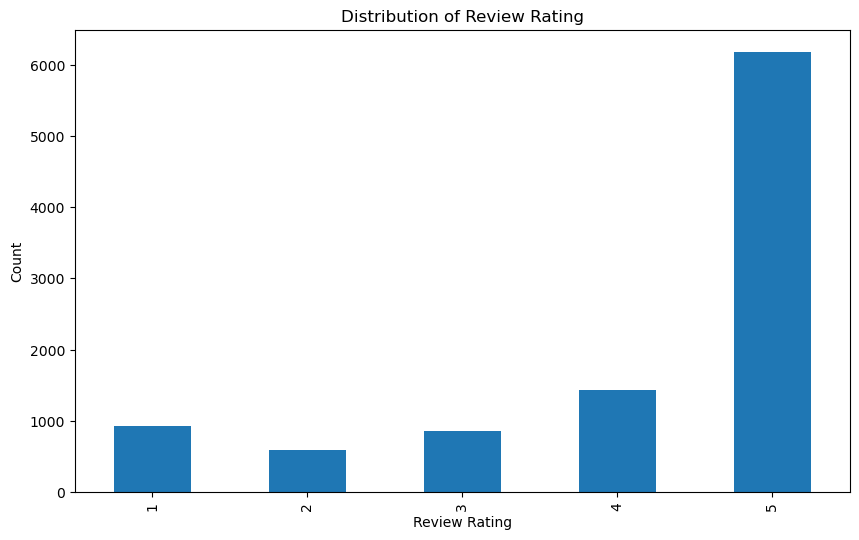

In [5]:
plt.figure(figsize = (10,6))
df["Score"].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Rating')
plt.xlabel('Review Rating')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

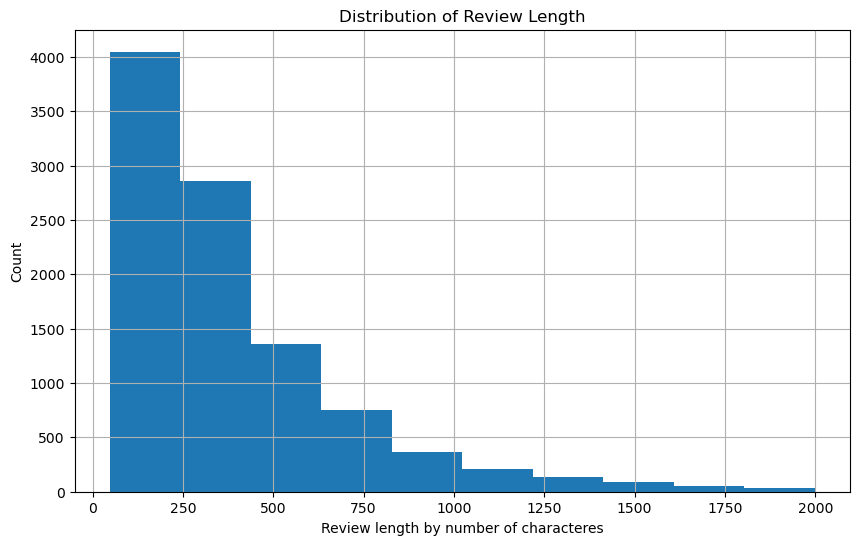

In [6]:
# Review Length
length = df["Text"].dropna().apply(lambda x: len(x))
plt.figure(figsize = (10,6))
length.loc[length < 2000].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length by number of characteres')
plt.ylabel('Count')

In [7]:
# Drop missing reviews
df = df.dropna(subset= [column])

newdf = df.drop_duplicates(subset=['ProductId', 'UserId'])



In [8]:
# make functions to detect the polarity
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

In [9]:
df['textblob_polarity'] = df[column].apply(detect_polarity)

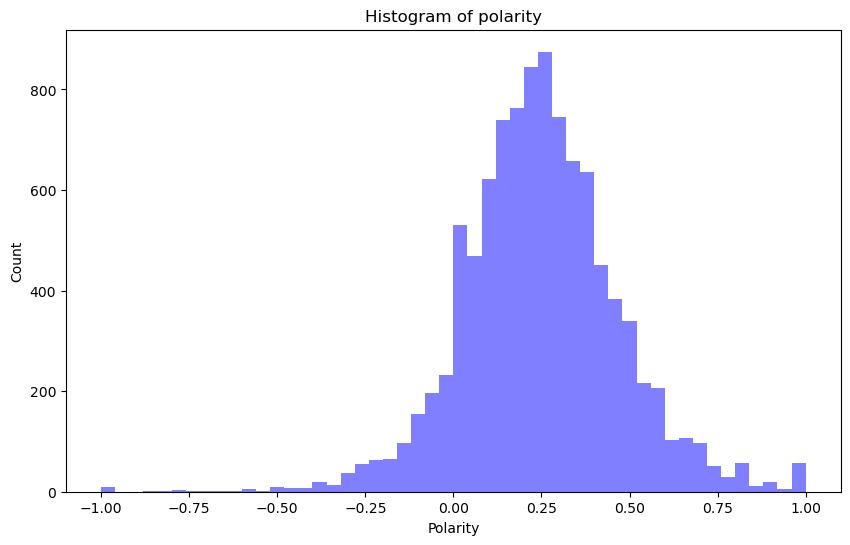

In [10]:
# check the distribution of polarity

num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df.textblob_polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

In [11]:
# --- examples -------
sentences = ["I'm very happy."]

analyzer = SentimentIntensityAnalyzer()

for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

I'm very happy.-------------------------------------------------- {'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}


In [12]:
# create function to use Vader to detect sentiment
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# execution
df['vader_polarity'] = df[column].apply(vader_sentiment)

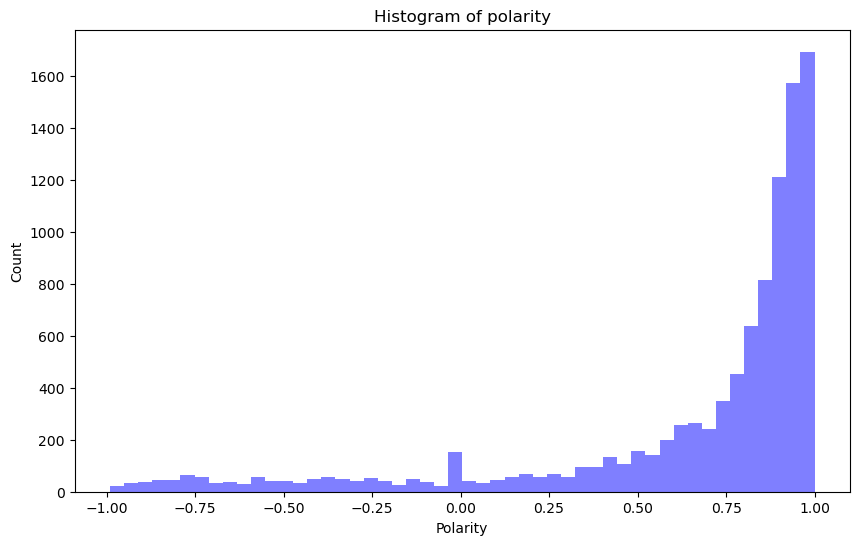

In [13]:
# check distribution of vender's sentiment results

num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df.vader_polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

In [14]:
import re
def clean(raw_text):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case

    return( " ".join(words))

In [15]:
df2 = newdf[newdf['rating_sentiment'] != "Neutral"].copy()

In [16]:
data2 = df2['Text']
clean_review2 = []
for document in data2:
    clean_review2.append(clean(document))
tokens2 = []
for review in clean_review2:
    tokens2.append(review.split())
print("An example:",  clean_review2[4])
print("An example:", tokens2[4])

An example: great taffy at a great price there was a wide assortment of yummy taffy delivery was very quick if your a taffy lover this is a deal
An example: ['great', 'taffy', 'at', 'a', 'great', 'price', 'there', 'was', 'a', 'wide', 'assortment', 'of', 'yummy', 'taffy', 'delivery', 'was', 'very', 'quick', 'if', 'your', 'a', 'taffy', 'lover', 'this', 'is', 'a', 'deal']


In [17]:
# Convert all the review text into a long string and print its length
raw_corpus = "".join(newdf['Text']+" ")
print("Raw Corpus contains {0:,} characters".format(len(raw_corpus)))

tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
# we tokenize the raw string into raw sentences
raw_sentences = tokenizer.tokenize(raw_corpus)
print("We have {0:,} raw sentences".format(len(raw_sentences)))

Raw Corpus contains 4,081,651 characters
We have 45,747 raw sentences


In [18]:
def clean_and_split_str(string):
    strip_special_chars = re.compile("[^A-Za-z]+")
    string = re.sub(strip_special_chars, " ", string)
    return string.strip().lower().split()

# clean each raw sentences and build the list of sentences
sentences = []
for raw_sent in raw_sentences:
    if len(raw_sent) > 0:
        sentences.append(clean_and_split_str(raw_sent))
print("We have {0:,} clean sentences".format(len(sentences)))
print("An example of a sentence:", sentences[3])

We have 45,747 clean sentences
An example of a sentence: ['product', 'arrived', 'labeled', 'as', 'jumbo', 'salted', 'peanuts', 'the', 'peanuts', 'were', 'actually', 'small', 'sized', 'unsalted']


In [19]:
token_count = sum([len(sentence) for sentence in sentences])
print("The dataset corpus contains {0:,} tokens".format(token_count))

The dataset corpus contains 767,586 tokens


In [20]:
import multiprocessing

#Dimensionality of the resulting word vectors
num_features = 300

#Minimum word count threshold
min_word_count = 3

#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()

#Context window length
context_size = 7

#Seed for the RNG, to make the result reproducible
seed = 1

In [21]:
word2vec_model = Word2Vec(sentences = sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    vector_size=num_features,
    min_count=min_word_count,
    window=context_size)

print("The vocabulary is built")
print("Word2Vec vocabulary length: ", len(word2vec_model.wv.index_to_key))

The vocabulary is built
Word2Vec vocabulary length:  8101


In [22]:
word2vec_model.save("amazon.model")

In [23]:
def averageVector(reviews, w2v):
    total = []
    lst = w2v.wv.index_to_key
    for review in reviews:
        avgVector = w2v.wv['i']*0
        count = 0
        empty = True
        for word in review:
            if word in lst:
                count += 1
                avgVector = np.add(avgVector, w2v.wv[word])
                empty = False
        if not empty:
            avgVector = np.divide(avgVector, count)
        total.append(avgVector)
    return total

In [24]:
allVectors2 = averageVector(tokens2, word2vec_model)

In [109]:
y2 = df2["rating_sentiment"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(pd.DataFrame(allVectors2), y2, test_size=0.2, random_state=42, stratify = y2)

In [110]:
svm2 = SVC(gamma='auto', class_weight = 'balanced')
svm2.fit(X_train2, y_train2) 

SVC(class_weight='balanced', gamma='auto')

In [111]:
y_pred_svm2 = svm2.predict(X_test2)

In [112]:
accuracy_score(y_test2, y_pred_svm2)

0.6039933444259568

In [113]:
print(classification_report(y_test2, y_pred_svm2))

              precision    recall  f1-score   support

    Negative       0.28      0.91      0.43       300
    Positive       0.97      0.54      0.70      1503

    accuracy                           0.60      1803
   macro avg       0.63      0.73      0.56      1803
weighted avg       0.85      0.60      0.65      1803



In [114]:
# Random Forest Classifier
rf2 = RandomForestClassifier(n_estimators=100)
rf2.fit(X_train2, y_train2)
y_pred_rf2 = rf2.predict(X_test2)

In [115]:
accuracy_score(y_test2, y_pred_rf2)

0.8646699944536883

In [116]:
print(classification_report(y_test2, y_pred_rf2))

              precision    recall  f1-score   support

    Negative       0.80      0.25      0.38       300
    Positive       0.87      0.99      0.92      1503

    accuracy                           0.86      1803
   macro avg       0.84      0.62      0.65      1803
weighted avg       0.86      0.86      0.83      1803



In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train2 = le.fit_transform(y_train2)
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X = X_train2,y =  y_train2)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred2 = classifier.predict(X_test2)
y_pred2 = le.inverse_transform(y_pred2)

accuracy_score(y_test2, y_pred2)

0.8763172490293955

In [119]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

    Negative       0.70      0.46      0.55       300
    Positive       0.90      0.96      0.93      1503

    accuracy                           0.88      1803
   macro avg       0.80      0.71      0.74      1803
weighted avg       0.86      0.88      0.87      1803

